In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import gensim
import spacy
import string
import core.model_utils as model_utils
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [2]:
df = pd.read_json('./../data/polish_translated/sarcasm/sarcasm_headlines_dataset_pl_with_tokens.json')
df.rename(columns={'is_sarcastic': 'label', 'headline_pl': 'text'}, inplace=True)
df

,label,text,tokens,joined_tokens
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...,"[naukowiec, rok, trzydziesty, odkrywać, zegar,...",naukowiec rok trzydziesty odkrywać zegar zagła...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko...","[reprezentantek, rząd, usa, wyjaśniać, kongres...",reprezentantek rząd usa wyjaśniać kongres brak...
2,0,Jedz warzywa: 9 pysznie różnych przepisów,"[jedz, warzywać, 9, pysznie, różny, przepis]",jedz warzywać 9 pysznie różny przepis
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...,"[nieprzyjemny, pogoda, uniemożliwiać, kłamca, ...",nieprzyjemny pogoda uniemożliwiać kłamca dotar...
4,1,"matka jest bardzo blisko użycia słowa ""streami...","[matka, blisko, użyć, słowo, streaming, popraw...",matka blisko użyć słowo streaming poprawnie
...,...,...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś,"[żydzi, świętować, rosh, hashasha]",żydzi świętować rosh hashasha
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...,"[śledczy, sprawa, wewnętrzny, rozczarować, spi...",śledczy sprawa wewnętrzny rozczarować spisk iś...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...,"[najpiękniejsza, przemowy, akceptacyjny, tydzi...",najpiękniejsza przemowy akceptacyjny tydzień p...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...,"[mars, zniszczona, pałac, kosmiczny, orbicie, ...",mars zniszczona pałac kosmiczny orbicie wrót g...


In [3]:
dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
dataset

Dataset({
    features: ['label', 'text', 'tokens', 'joined_tokens'],
    num_rows: 28619
})

In [4]:
# Train set: 80%, Validation set: 10%, Test set: 10%
_, _, test_dataset = model_utils.split_train_val_test(
    dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [5]:
# Load models
version = "1"
trained_bert = os.path.join("./../trained_models/sarcasm_pl_bert_4", version)
trained_gpt = os.path.join("./../trained_models/sarcasm_pl_gpt2_4", version)

bert = tf.keras.models.load_model(trained_bert)
gpt2 = tf.keras.models.load_model(trained_gpt)

In [6]:
# Create BERT tokenizer and collator
bert_checkpoint = "dkleczek/bert-base-polish-uncased-v1"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint, model_max_length=512)


def tokenize_for_bert(example):
    return bert_tokenizer(example["text"], truncation=True)


bert_tokenized_test_dataset = test_dataset.map(tokenize_for_bert, batched=True)

bert_input_columns = ["attention_mask", "input_ids", "token_type_ids"]
bert_label_columns = ['label']
bert_batch_size = 16
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, return_tensors="tf")
bert_tf_dataset = model_utils.convert_to_tf_dataset(bert_tokenized_test_dataset, bert_input_columns, bert_label_columns,
                                                    bert_data_collator, bert_batch_size)

Map:   0%|          | 0/2862 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [7]:
# Create GPT2 tokenizer
gpt_checkpoint = MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

gpt2_tokenizer.padding_side = "left"


def tokenize_for_gpt2(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text']]

    output = gpt2_tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


gpt2_tokenized_test_dataset = test_dataset.map(tokenize_for_gpt2, batched=True)

gpt2_input_columns = ["input_ids", "attention_mask"]
gpt2_label_columns = ["label"]
gpt2_batch_size = 16
gpt2_data_collator = DataCollatorWithPadding(tokenizer=gpt2_tokenizer, return_tensors="tf")
gpt2_tf_dataset = model_utils.convert_to_tf_dataset(gpt2_tokenized_test_dataset, gpt2_input_columns, gpt2_label_columns,
                                                    gpt2_data_collator, gpt2_batch_size)

Map:   0%|          | 0/2862 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [8]:
def combine_probabilities(model1_probabilities, model2_probabilities, model1_weights, model2_weights):
    weighted_avg_probabilities = (
                                         model1_weights * model1_probabilities + model2_weights * model2_probabilities) / (
                                         model1_weights + model2_weights)
    normalized_probabilities = weighted_avg_probabilities / np.sum(weighted_avg_probabilities, axis=1, keepdims=True)

    return normalized_probabilities


def hybrid_predict(bert_input, gpt2_input, bert_model, gpt2_model, bert_weights,
                   gpt2_weights, return_classes=True):
    bert_probabilities = model_utils.get_class_preds(bert_model, bert_input, return_classes=False)
    gpt2_probabilities = model_utils.get_class_preds(gpt2_model, gpt2_input, return_classes=False)
    final_output = combine_probabilities(bert_probabilities, gpt2_probabilities, bert_weights,
                                         gpt2_weights)
    if return_classes:
        final_output = np.argmax(final_output, axis=1)
    return final_output

In [9]:
bert_weights = np.array([83, 90])
gpt2_weights = np.array([83, 0])

hybrid_preds = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset,
    bert_model=bert, gpt2_model=gpt2,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights,
)

hybrid_preds_probas = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset,
    bert_model=bert, gpt2_model=gpt2,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights,
    return_classes=False
)

In [10]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['label'],
    class_preds=hybrid_preds,
)

accuracy = accuracy_score(test_dataset['label'], hybrid_preds)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
loss = loss(test_dataset['label'], hybrid_preds_probas).numpy()

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)
print(f"Accuracy: ", accuracy)
print(f"Loss: ", loss)

Precision score:  0.8959677419354839
Recall score:  0.8033261026753434
F1 score:  0.8471216164696911
Accuracy:  0.8598881900768693
Loss:  0.3361778259277344


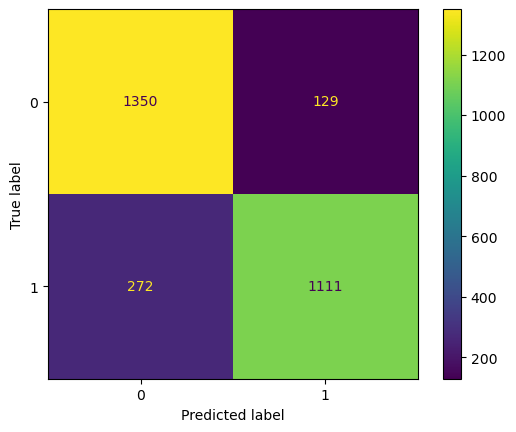

In [11]:
training_name = "basic_best_from_only_bert_gpt"
figures_dir = "./../documentation/models/sarcasm_pl_hybrid/figures"

model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['label'],
                                      class_preds=hybrid_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix")

In [12]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['text'],
                                              class_actual=test_dataset['label'],
                                              class_preds=hybrid_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: "New York Times": tyran wybija stos sondaży z rąk Nate'a Silvera
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: hare krishnas: 'hare krishna, hare krishna, krishna krishna, hare hare'
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 9
            - TEXT: Nawet księżna lubi dobrą umowę
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 12
            - TEXT: Pier 1 wydało oficjalne przeprosiny za marsz śmierci w Rattan
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 20
            - TEXT: Andrew W.K. zajmuje stanowisko zagorzałego rzecznika partii
            - PREDICTED VALUE: 0
       

In [13]:
test_df = pd.DataFrame(
    list(zip(test_dataset['text'], test_dataset['label'], hybrid_preds)),
    columns=['text', 'label', 'prediction'])
test_df

,text,label,prediction
0,"Szef uważa, że kobieta pracownik może być goto...",1,1
1,"""New York Times"": tyran wybija stos sondaży z ...",1,0
2,"przygotuj się na lizanie w tej przyczepie ""for...",0,0
3,"hare krishnas: 'hare krishna, hare krishna, kr...",1,0
4,Powerball wyciąga plastikowe kulki z solanki z...,1,1
...,...,...,...
2857,Lena Dunham na czerwonym dywanie,0,0
2858,PayPal wycofuje się po tymczasowej globalnej p...,0,1
2859,Naród zrzuca tyrańskie jarzmo umiarkowanego sz...,1,1
2860,Jonathan Rhys Meyers przeprasza za zdjęcia,0,0


In [14]:
def map_token_counts(row):
    return len(row['text'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['label'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text,label,prediction,token_count,count_belonging,correctly_predicted
0,"Szef uważa, że kobieta pracownik może być goto...",1,1,16,12-17,1
1,"""New York Times"": tyran wybija stos sondaży z ...",1,0,11,6-11,0
2,"przygotuj się na lizanie w tej przyczepie ""for...",0,0,13,12-17,1
3,"hare krishnas: 'hare krishna, hare krishna, kr...",1,0,10,6-11,0
4,Powerball wyciąga plastikowe kulki z solanki z...,1,1,9,6-11,1
...,...,...,...,...,...,...
2857,Lena Dunham na czerwonym dywanie,0,0,5,0-5,1
2858,PayPal wycofuje się po tymczasowej globalnej p...,0,1,7,6-11,0
2859,Naród zrzuca tyrańskie jarzmo umiarkowanego sz...,1,1,8,6-11,1
2860,Jonathan Rhys Meyers przeprasza za zdjęcia,0,0,6,6-11,1


In [15]:
test_df = test_df.drop(test_df[test_df.token_count > 23].index)

In [16]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

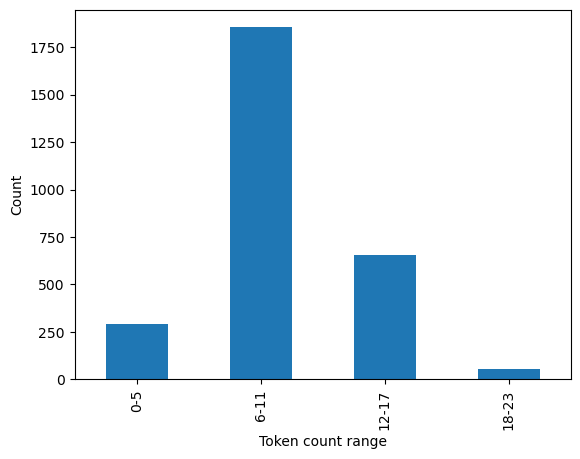

In [17]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [18]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0.}

In [19]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 244, '6-11': 1578, '12-17': 580, '18-23': 55}
Element count:  {'0-5': 291, '6-11': 1855, '12-17': 654, '18-23': 57}
Accuracies:  {'0-5': 0.8384879725085911, '6-11': 0.8506738544474394, '12-17': 0.8868501529051988, '18-23': 0.9649122807017544}


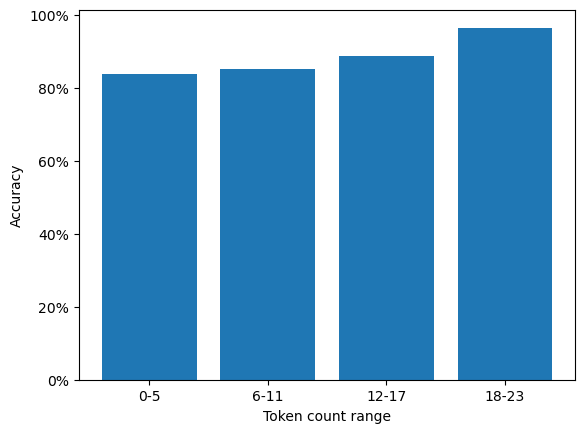

In [20]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()